In [ ]:
# ----------------------
# 1. Imports and Dataset
# ----------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    classification_report, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
)
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import time
import warnings
warnings.filterwarnings("ignore")

In [ ]:

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset
try:
    df = pd.read_csv('/content/spambase_csv.csv')
    print("Dataset loaded successfully!")
except:
    print("Please download the dataset from Kaggle and name it 'spambase_csv.csv'")
    exit()

Dataset loaded successfully!



========== EDA Analysis (Top Features) ==========


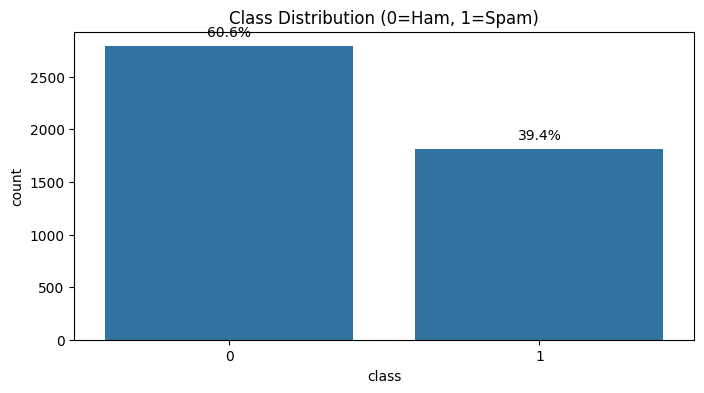

In [ ]:
# ---------------------
# 2. Focused Exploratory Data Analysis (EDA)
# ---------------------
print("\n========== EDA Analysis (Top Features) ==========")

# 1. Class Balance
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='class', data=df)
plt.title('Class Distribution (0=Ham, 1=Spam)')
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 0.02*total
    ax.annotate(percentage, (x, y), ha='center')
plt.show()

In [ ]:

# 2. Top 10 Most Important Features (by absolute correlation with target)
correlations = df.corr()['class'].abs().sort_values(ascending=False)
top_10_features = correlations[1:11].index  # Skip 'class' itself

print("\nTop Features Correlated with Class:")
print(correlations[1:11])


Top Features Correlated with Class:
word_freq_your              0.383234
word_freq_000               0.334787
word_freq_remove            0.332117
char_freq_%24               0.323629
word_freq_you               0.273651
word_freq_free              0.263215
word_freq_business          0.263204
word_freq_hp                0.256723
capital_run_length_total    0.249164
word_freq_our               0.241920
Name: class, dtype: float64


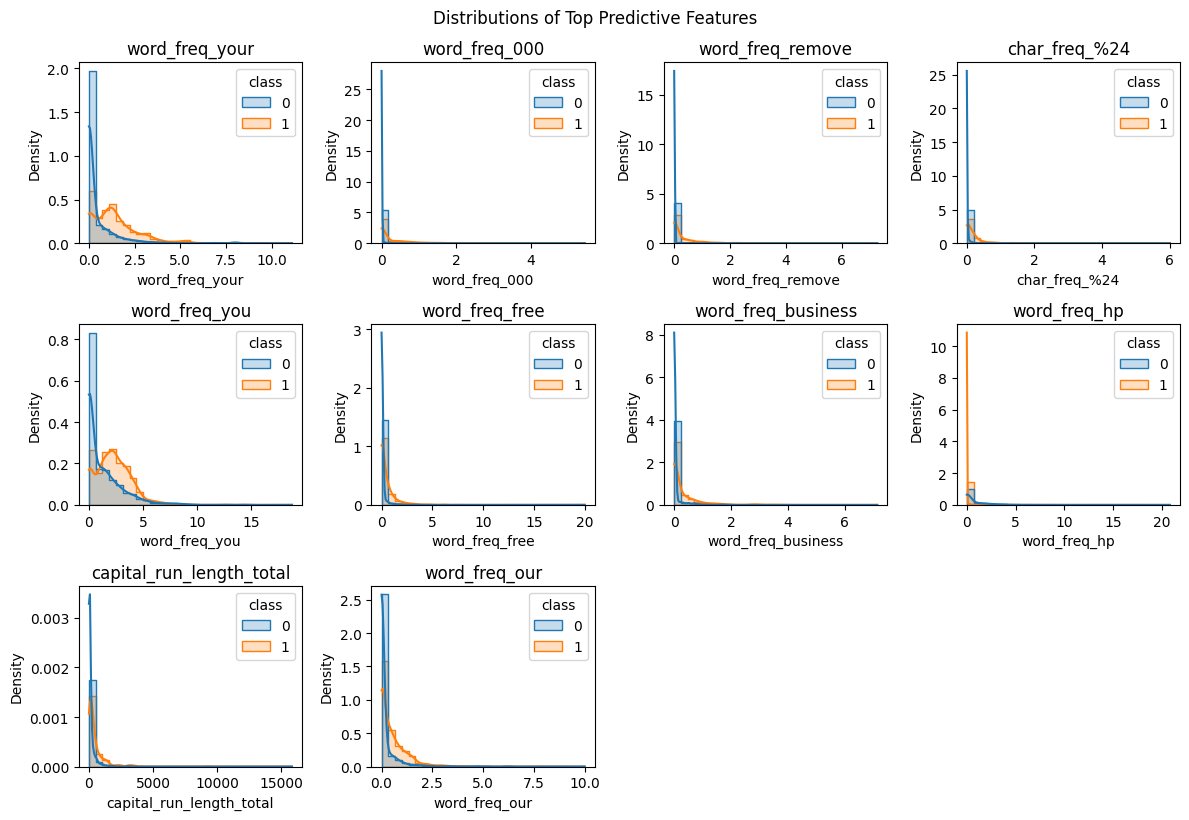

In [ ]:
# 3. Distribution of Top 10 Features
plt.figure(figsize=(12, 8))
for i, feature in enumerate(top_10_features, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data=df, x=feature, hue='class', kde=True, bins=30,
                 element='step', stat='density', common_norm=False)
    plt.title(feature)
plt.tight_layout()
plt.suptitle('Distributions of Top Predictive Features', y=1.02)
plt.show()

In [ ]:
# ---------------------
# 3. Data Preprocessing
# ---------------------
print("\n========== Data Preprocessing ==========")

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum().sum())  # Should be 0 for this dataset

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Create scaled versions for algorithms that need it
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

minmax_scaler = MinMaxScaler()
X_minmax = minmax_scaler.fit_transform(X)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X_minmax, y, test_size=0.2, random_state=42)



========== Data Preprocessing ==========

Missing Values:
0


In [ ]:
# ---------------------
# 4. Evaluation Functions
# ---------------------
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name=""):
    """Evaluate a model and return metrics"""
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'train_time': train_time
    }

    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_test, y_proba)

    # Display results
    print(f"\n--- {model_name} Results ---")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    if 'roc_auc' in metrics:
        print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    print(f"Training Time: {metrics['train_time']:.4f}s")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # ROC Curve (if probabilities available)
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()

    return metrics

def cross_validate_model(model, X, y, model_name="", k=5):
    """Perform k-fold cross validation and return results"""
    print(f"\n--- {model_name} {k}-Fold Cross Validation ---")

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Metrics to collect
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'fit_time': [],
        'score_time': []
    }

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        start_time = time.time()
        model.fit(X_train, y_train)
        fit_time = time.time() - start_time

        start_time = time.time()
        y_pred = model.predict(X_test)
        score_time = time.time() - start_time

        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred))
        metrics['recall'].append(recall_score(y_test, y_pred))
        metrics['f1'].append(f1_score(y_test, y_pred))
        metrics['fit_time'].append(fit_time)
        metrics['score_time'].append(score_time)

        print(f"Fold {fold}: Accuracy = {metrics['accuracy'][-1]:.4f}, F1 = {metrics['f1'][-1]:.4f}")

    # Calculate averages
    avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
    print(f"\nAverage {k}-fold CV Results:")
    print(f"Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Precision: {avg_metrics['precision']:.4f}")
    print(f"Recall: {avg_metrics['recall']:.4f}")
    print(f"F1 Score: {avg_metrics['f1']:.4f}")
    print(f"Fit Time: {avg_metrics['fit_time']:.4f}s")
    print(f"Score Time: {avg_metrics['score_time']:.4f}s")

    return avg_metrics


========== Naive Bayes Models ==========

--- GaussianNB Results ---
Accuracy: 0.8219
Precision: 0.7233
Recall: 0.9385
F1 Score: 0.8170
ROC AUC: 0.9269
Training Time: 0.0049s


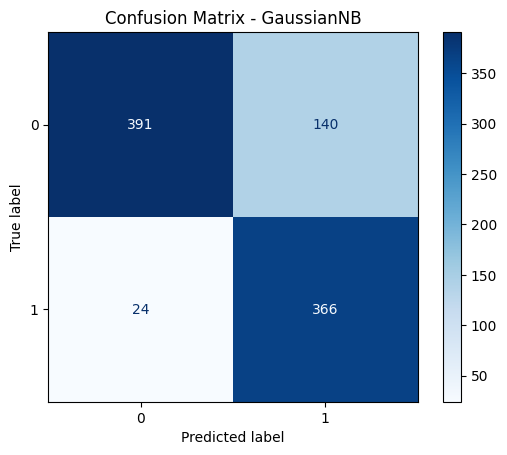

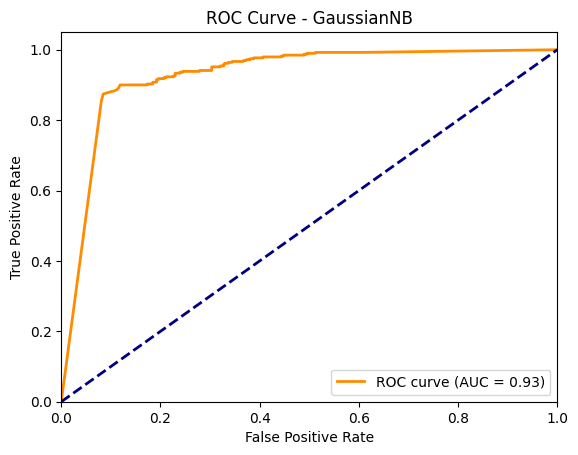


--- GaussianNB 5-Fold Cross Validation ---
Fold 1: Accuracy = 0.8219, F1 = 0.8170
Fold 2: Accuracy = 0.8033, F1 = 0.7959
Fold 3: Accuracy = 0.7946, F1 = 0.7835
Fold 4: Accuracy = 0.8228, F1 = 0.8043
Fold 5: Accuracy = 0.8337, F1 = 0.8145

Average 5-fold CV Results:
Accuracy: 0.8153
Precision: 0.6933
Recall: 0.9557
F1 Score: 0.8031
Fit Time: 0.0046s
Score Time: 0.0009s

--- MultinomialNB Results ---
Accuracy: 0.8719
Precision: 0.9503
Recall: 0.7359
F1 Score: 0.8295
ROC AUC: 0.9591
Training Time: 0.0023s


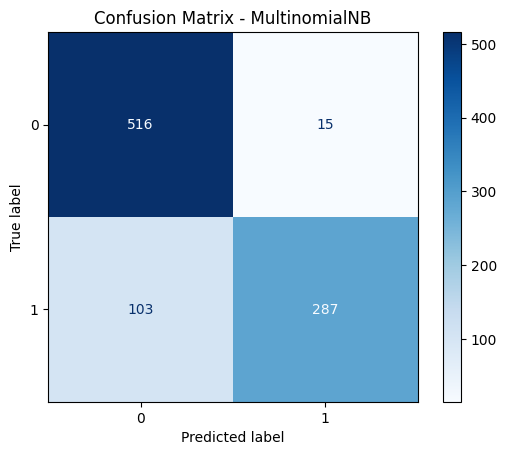

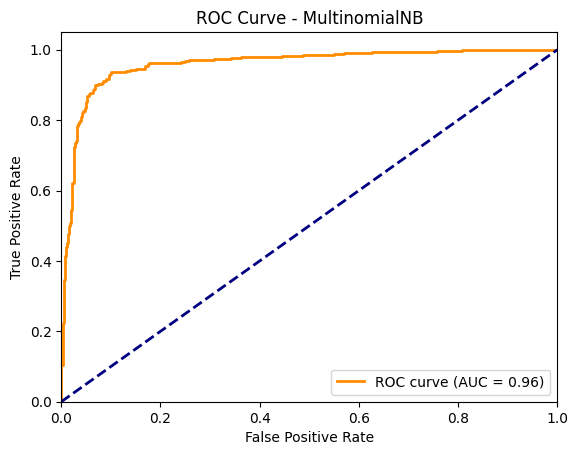


--- MultinomialNB 5-Fold Cross Validation ---
Fold 1: Accuracy = 0.8719, F1 = 0.8295
Fold 2: Accuracy = 0.8935, F1 = 0.8533
Fold 3: Accuracy = 0.8891, F1 = 0.8411
Fold 4: Accuracy = 0.8913, F1 = 0.8438
Fold 5: Accuracy = 0.8859, F1 = 0.8382

Average 5-fold CV Results:
Accuracy: 0.8863
Precision: 0.9364
Recall: 0.7639
F1 Score: 0.8412
Fit Time: 0.0025s
Score Time: 0.0004s

--- BernoulliNB Results ---
Accuracy: 0.8806
Precision: 0.9046
Recall: 0.8026
F1 Score: 0.8505
ROC AUC: 0.9569
Training Time: 0.0052s


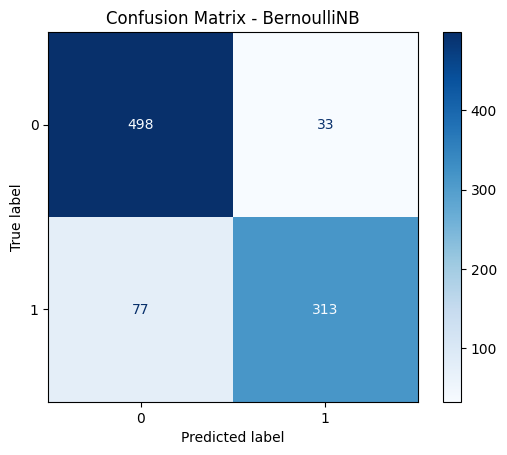

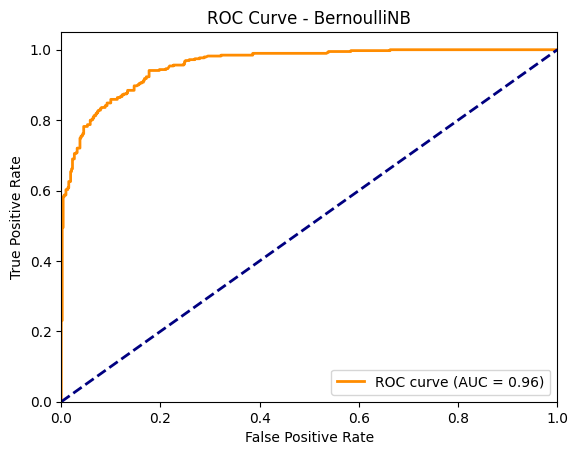


--- BernoulliNB 5-Fold Cross Validation ---
Fold 1: Accuracy = 0.8806, F1 = 0.8505
Fold 2: Accuracy = 0.8935, F1 = 0.8627
Fold 3: Accuracy = 0.8891, F1 = 0.8555
Fold 4: Accuracy = 0.8870, F1 = 0.8448
Fold 5: Accuracy = 0.8902, F1 = 0.8508

Average 5-fold CV Results:
Accuracy: 0.8881
Precision: 0.8844
Recall: 0.8244
F1 Score: 0.8529
Fit Time: 0.0051s
Score Time: 0.0012s

Table 1: Performance Comparison of Naive Bayes Variants
Model           Accuracy   Precision  Recall     F1 Score   ROC AUC   
GaussianNB      0.8219     0.7233     0.9385     0.8170     0.9269    
MultinomialNB   0.8719     0.9503     0.7359     0.8295     0.9591    
BernoulliNB     0.8806     0.9046     0.8026     0.8505     0.9569    


In [ ]:
# ---------------------
# 5. Naive Bayes Models
# ---------------------
print("\n========== Naive Bayes Models ==========")

# Initialize models
nb_models = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB()
}

# Store results
nb_results = []
nb_cv_results = []

# Evaluate each NB variant
for name, model in nb_models.items():
    # Select appropriate data (scaled for Gaussian, raw for others)
    if name == 'GaussianNB':
        X_train_data, X_test_data = X_train, X_test
        y_train_data, y_test_data = y_train, y_test
    else:
        X_train_data, X_test_data = X_train_mm, X_test_mm  # MinMax scaled for Multinomial/Bernoulli
        y_train_data, y_test_data = y_train_mm, y_test_mm

    # Evaluate on test set
    metrics = evaluate_model(model, X_train_data, y_train_data, X_test_data, y_test_data, name)
    nb_results.append((name, metrics))

    # Cross validation
    cv_metrics = cross_validate_model(model, X_scaled if name == 'GaussianNB' else X_minmax, y, name)
    nb_cv_results.append((name, cv_metrics))

# Display comparison table
print("\nTable 1: Performance Comparison of Naive Bayes Variants")
print("{:<15} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
    "Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"))
for name, metrics in nb_results:
    print("{:<15} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        name, metrics['accuracy'], metrics['precision'],
        metrics['recall'], metrics['f1'], metrics.get('roc_auc', 0)))



========== K-Nearest Neighbors ==========

--- KNN with Different k Values ---

--- KNN (k=1) Results ---
Accuracy: 0.8958
Precision: 0.8769
Recall: 0.8769
F1 Score: 0.8769
ROC AUC: 0.8933
Training Time: 0.0017s


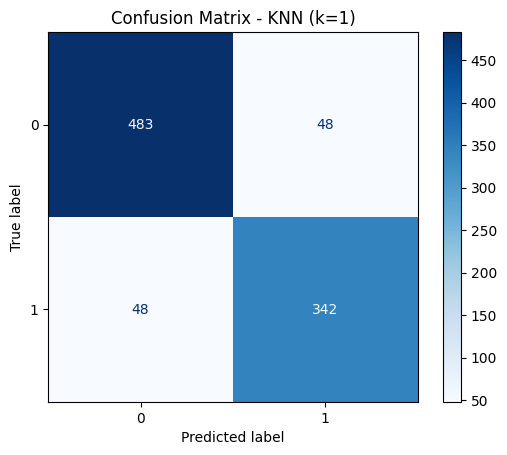

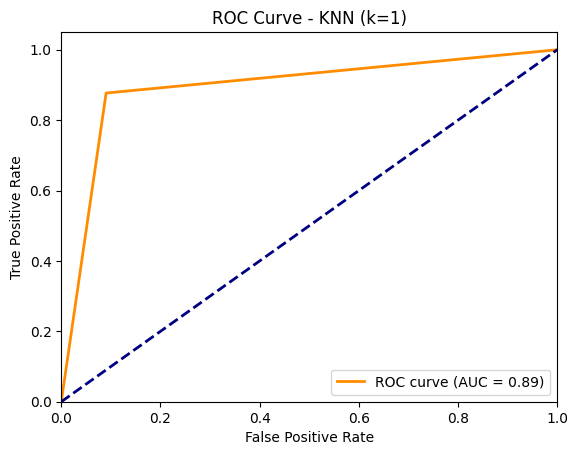


--- KNN (k=3) Results ---
Accuracy: 0.8936
Precision: 0.8883
Recall: 0.8564
F1 Score: 0.8721
ROC AUC: 0.9351
Training Time: 0.0018s


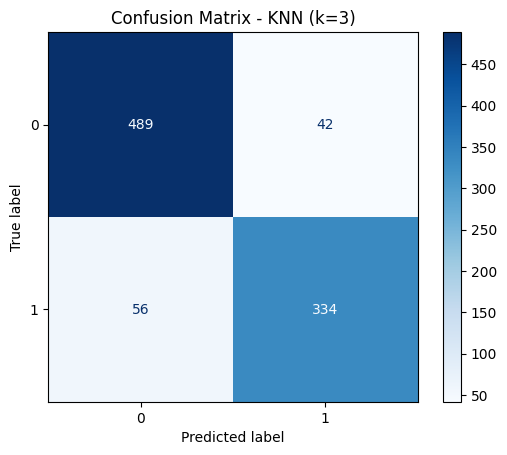

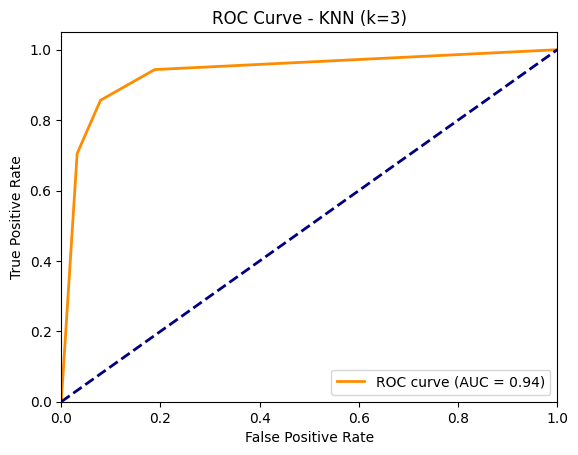


--- KNN (k=5) Results ---
Accuracy: 0.8958
Precision: 0.9016
Recall: 0.8462
F1 Score: 0.8730
ROC AUC: 0.9445
Training Time: 0.0017s


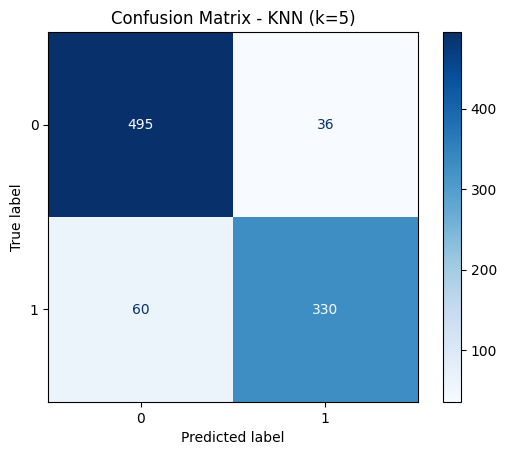

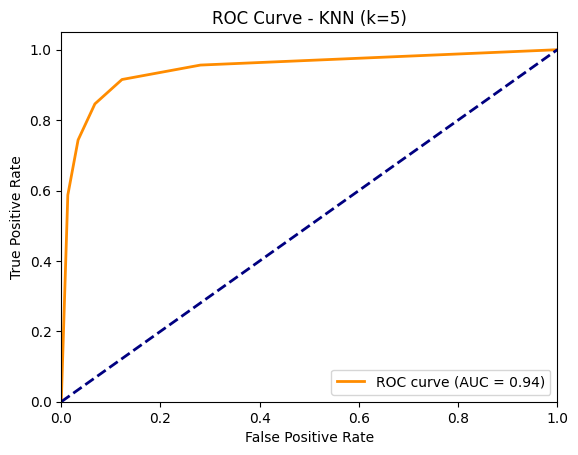


--- KNN (k=7) Results ---
Accuracy: 0.8958
Precision: 0.9106
Recall: 0.8359
F1 Score: 0.8717
ROC AUC: 0.9511
Training Time: 0.0016s


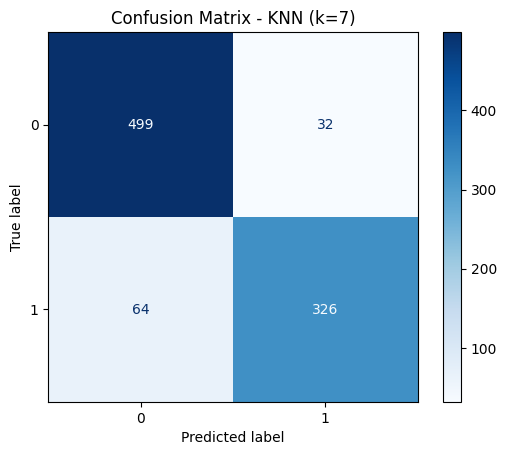

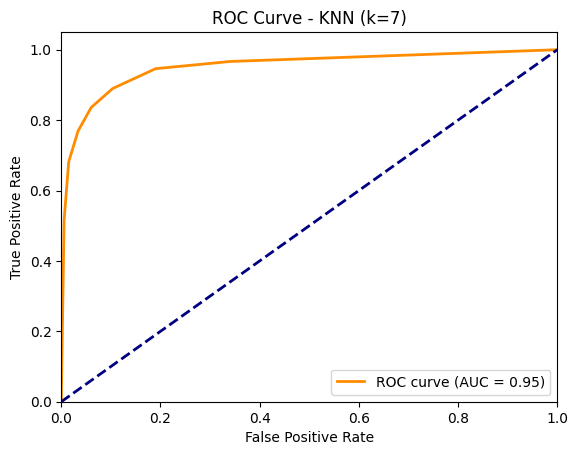


Table 2: KNN Performance for Different k Values
k     Accuracy   Precision  Recall     F1 Score   ROC AUC   
1     0.8958     0.8769     0.8769     0.8769     0.8933    
3     0.8936     0.8883     0.8564     0.8721     0.9351    
5     0.8958     0.9016     0.8462     0.8730     0.9445    
7     0.8958     0.9106     0.8359     0.8717     0.9511    

--- KNN with Different Algorithms ---

--- KNN (kd_tree) Results ---
Accuracy: 0.8958
Precision: 0.9016
Recall: 0.8462
F1 Score: 0.8730
ROC AUC: 0.9445
Training Time: 0.0385s


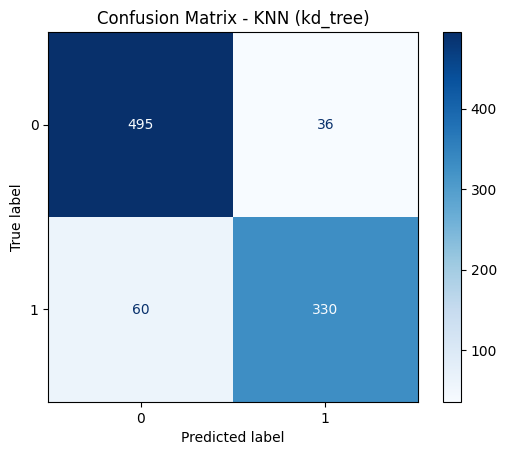

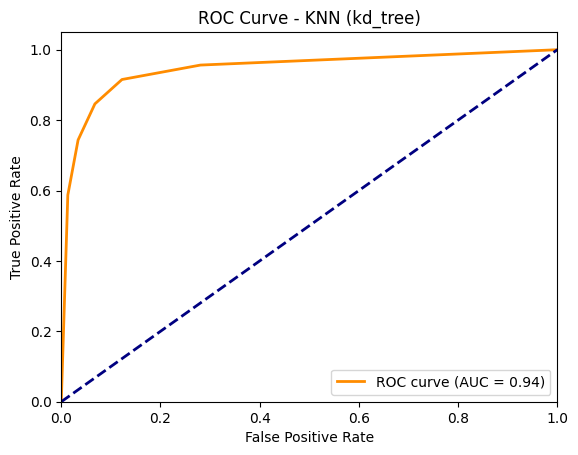


--- KNN (ball_tree) Results ---
Accuracy: 0.8958
Precision: 0.9016
Recall: 0.8462
F1 Score: 0.8730
ROC AUC: 0.9445
Training Time: 0.0205s


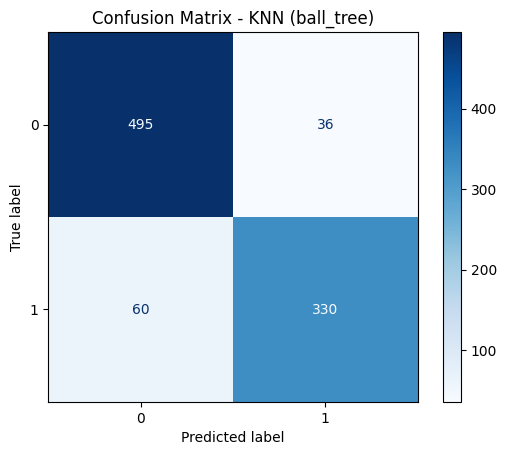

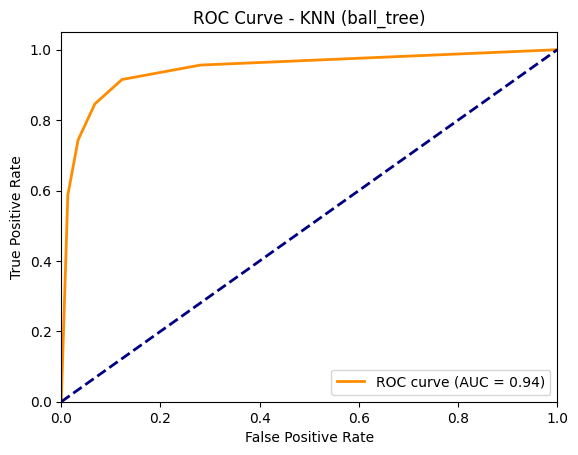


Table 3: KNN Comparison: KDTree vs BallTree
Algorithm  Accuracy   Precision  Recall     F1 Score   Training Time  
kd_tree    0.8958     0.9016     0.8462     0.8730     0.0385         
ball_tree  0.8958     0.9016     0.8462     0.8730     0.0205         

--- KNN (k=5) 5-Fold Cross Validation ---
Fold 1: Accuracy = 0.8958, F1 = 0.8730
Fold 2: Accuracy = 0.9043, F1 = 0.8778
Fold 3: Accuracy = 0.9293, F1 = 0.9062
Fold 4: Accuracy = 0.9033, F1 = 0.8708
Fold 5: Accuracy = 0.9098, F1 = 0.8819

Average 5-fold CV Results:
Accuracy: 0.9085
Precision: 0.8983
Recall: 0.8663
F1 Score: 0.8820
Fit Time: 0.0011s
Score Time: 0.0295s


In [ ]:
# ---------------------
# 6. KNN Models
# ---------------------
print("\n========== K-Nearest Neighbors ==========")

# Varying k values
print("\n--- KNN with Different k Values ---")
k_values = [1, 3, 5, 7]
knn_results = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test, f"KNN (k={k})")
    knn_results.append((k, metrics))

# Display comparison table
print("\nTable 2: KNN Performance for Different k Values")
print("{:<5} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
    "k", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"))
for k, metrics in knn_results:
    print("{:<5} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        k, metrics['accuracy'], metrics['precision'],
        metrics['recall'], metrics['f1'], metrics.get('roc_auc', 0)))

# KDTree vs BallTree
print("\n--- KNN with Different Algorithms ---")
knn_algo_results = []
algorithms = ['kd_tree', 'ball_tree']

for algo in algorithms:
    model = KNeighborsClassifier(n_neighbors=5, algorithm=algo)
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test, f"KNN ({algo})")
    knn_algo_results.append((algo, metrics))

# Display comparison table
print("\nTable 3: KNN Comparison: KDTree vs BallTree")
print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<15}".format(
    "Algorithm", "Accuracy", "Precision", "Recall", "F1 Score", "Training Time"))
for algo, metrics in knn_algo_results:
    print("{:<10} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<15.4f}".format(
        algo, metrics['accuracy'], metrics['precision'],
        metrics['recall'], metrics['f1'], metrics['train_time']))

# Cross validation for best KNN
best_knn = KNeighborsClassifier(n_neighbors=5)
cv_metrics = cross_validate_model(best_knn, X_scaled, y, "KNN (k=5)")



========== Support Vector Machines ==========

--- Linear SVM Results ---
Accuracy: 0.9251
Precision: 0.9350
Recall: 0.8846
F1 Score: 0.9091
ROC AUC: 0.9732
Training Time: 3.6799s


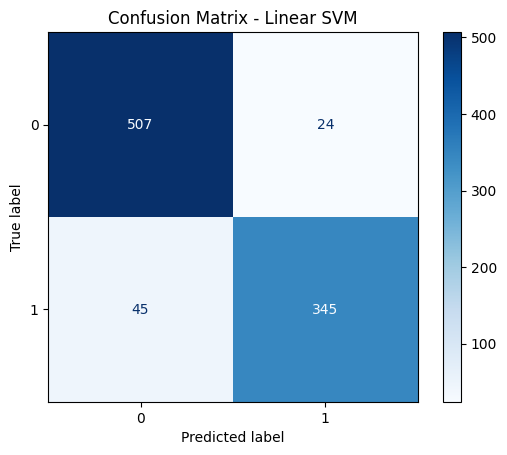

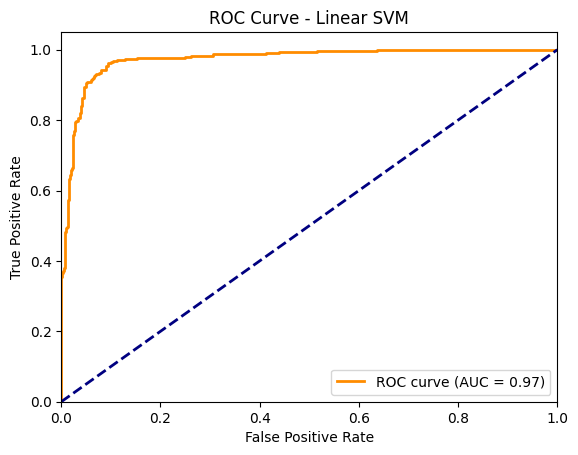


--- Polynomial SVM (d=2) Results ---
Accuracy: 0.8393
Precision: 0.9515
Recall: 0.6538
F1 Score: 0.7751
ROC AUC: 0.9514
Training Time: 2.5147s


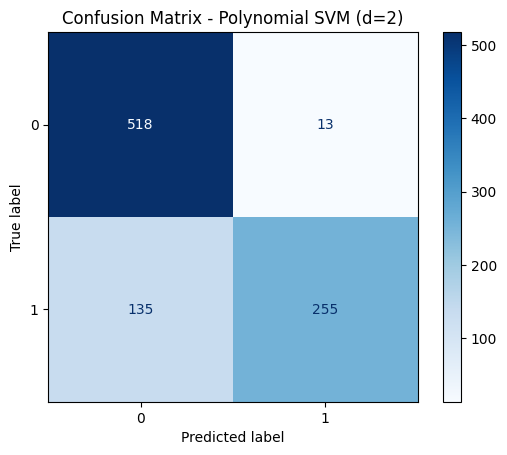

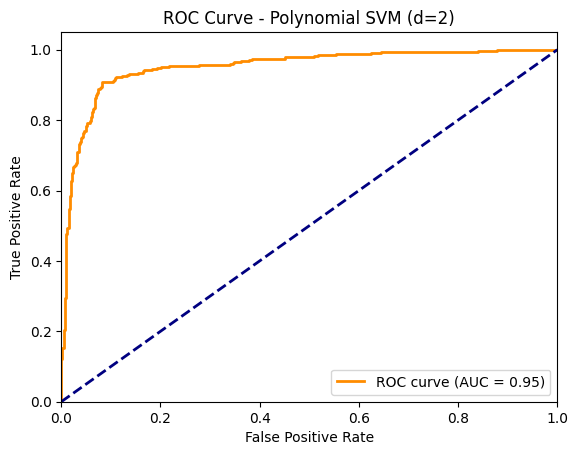


--- Polynomial SVM (d=3) Results ---
Accuracy: 0.7644
Precision: 0.9436
Recall: 0.4718
F1 Score: 0.6291
ROC AUC: 0.9554
Training Time: 2.8573s


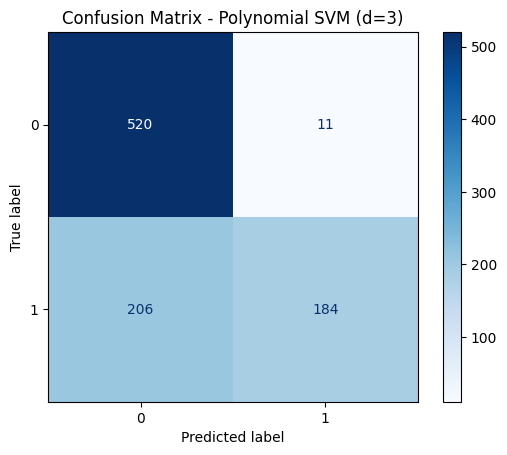

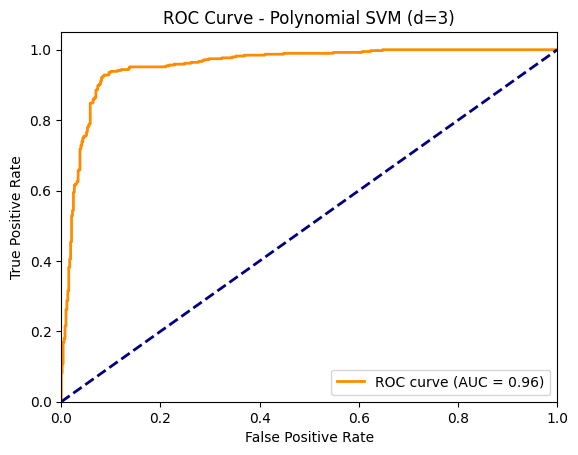


--- RBF SVM (γ=scale) Results ---
Accuracy: 0.9349
Precision: 0.9508
Recall: 0.8923
F1 Score: 0.9206
ROC AUC: 0.9787
Training Time: 1.8059s


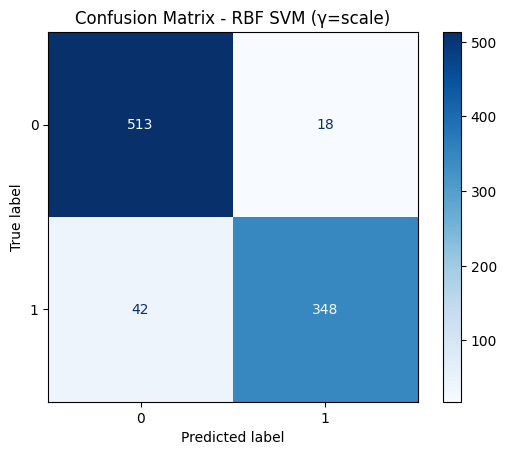

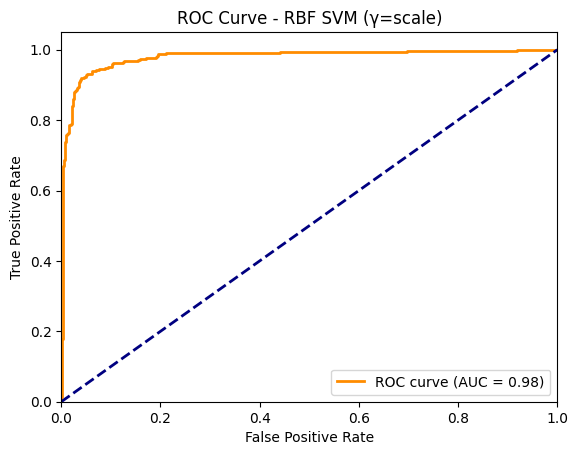


--- Sigmoid SVM Results ---
Accuracy: 0.8893
Precision: 0.8850
Recall: 0.8487
F1 Score: 0.8665
ROC AUC: 0.9372
Training Time: 2.2649s


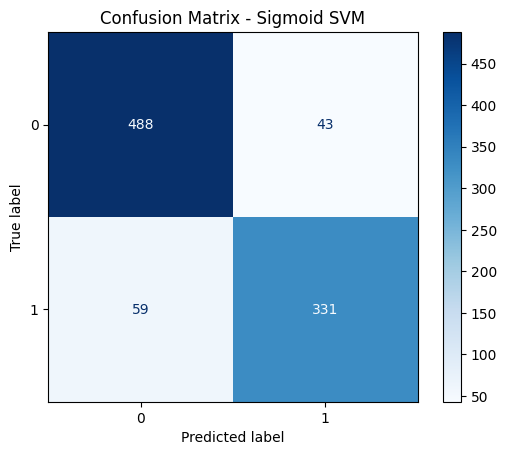

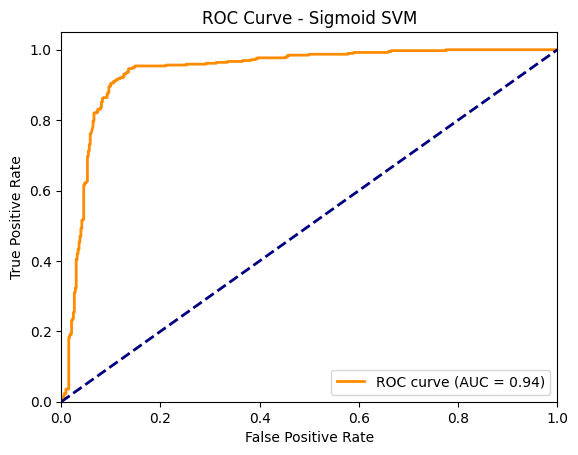


Table 4: SVM Performance with Different Kernels
Kernel               Accuracy   Precision  Recall     F1 Score   ROC AUC   
Linear SVM           0.9251     0.9350     0.8846     0.9091     0.9732    
Polynomial SVM (d=2) 0.8393     0.9515     0.6538     0.7751     0.9514    
Polynomial SVM (d=3) 0.7644     0.9436     0.4718     0.6291     0.9554    
RBF SVM (γ=scale)    0.9349     0.9508     0.8923     0.9206     0.9787    
Sigmoid SVM          0.8893     0.8850     0.8487     0.8665     0.9372    

--- RBF SVM 5-Fold Cross Validation ---
Fold 1: Accuracy = 0.9349, F1 = 0.9206
Fold 2: Accuracy = 0.9337, F1 = 0.9149
Fold 3: Accuracy = 0.9228, F1 = 0.8978
Fold 4: Accuracy = 0.9359, F1 = 0.9126
Fold 5: Accuracy = 0.9304, F1 = 0.9083

Average 5-fold CV Results:
Accuracy: 0.9315
Precision: 0.9333
Recall: 0.8896
F1 Score: 0.9109
Fit Time: 1.9054s
Score Time: 0.1067s


In [ ]:
# ---------------------
# 7. SVM Models
# ---------------------
print("\n========== Support Vector Machines ==========")

# Different kernels
svm_models = {
    'Linear SVM': SVC(kernel='linear', C=1.0, probability=True, random_state=42),
    'Polynomial SVM (d=2)': SVC(kernel='poly', degree=2, C=1.0, probability=True, random_state=42),
    'Polynomial SVM (d=3)': SVC(kernel='poly', degree=3, C=1.0, probability=True, random_state=42),
    'RBF SVM (γ=scale)': SVC(kernel='rbf', gamma='scale', C=1.0, probability=True, random_state=42),
    'Sigmoid SVM': SVC(kernel='sigmoid', C=1.0, probability=True, random_state=42)
}

svm_results = []

for name, model in svm_models.items():
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    svm_results.append((name, metrics))

# Display comparison table
print("\nTable 4: SVM Performance with Different Kernels")
print("{:<20} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
    "Kernel", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"))
for name, metrics in svm_results:
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        name, metrics['accuracy'], metrics['precision'],
        metrics['recall'], metrics['f1'], metrics.get('roc_auc', 0)))

# Cross validation for best SVM
best_svm = SVC(kernel='rbf', gamma='scale', C=1.0, probability=True, random_state=42)
cv_metrics = cross_validate_model(best_svm, X_scaled, y, "RBF SVM")



========== Final Model Comparison ==========

Evaluating Best Models on Test Data:

Best Naive Bayes Model: BernoulliNB

--- Best Naive Bayes (BernoulliNB) Results ---
Accuracy: 0.8806
Precision: 0.9046
Recall: 0.8026
F1 Score: 0.8505
ROC AUC: 0.9569
Training Time: 0.0052s


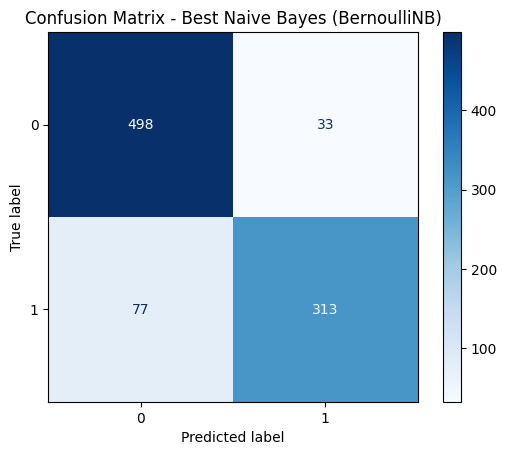

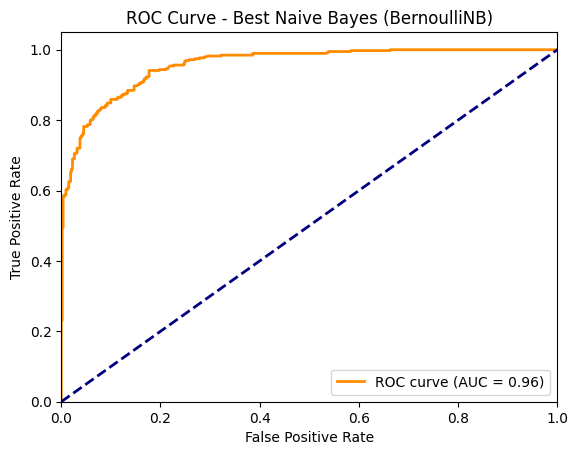

Best KNN Model: k=1

--- Best KNN (k=1) Results ---
Accuracy: 0.8958
Precision: 0.8769
Recall: 0.8769
F1 Score: 0.8769
ROC AUC: 0.8933
Training Time: 0.0018s


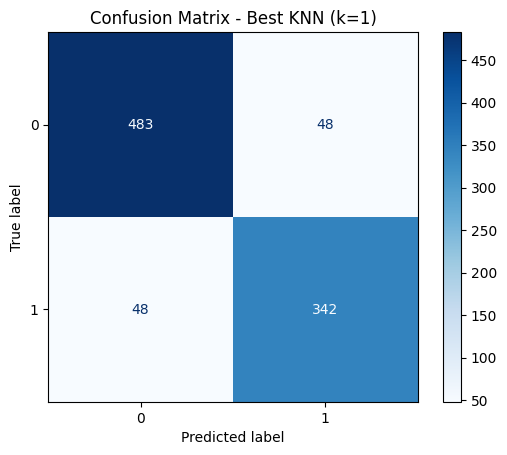

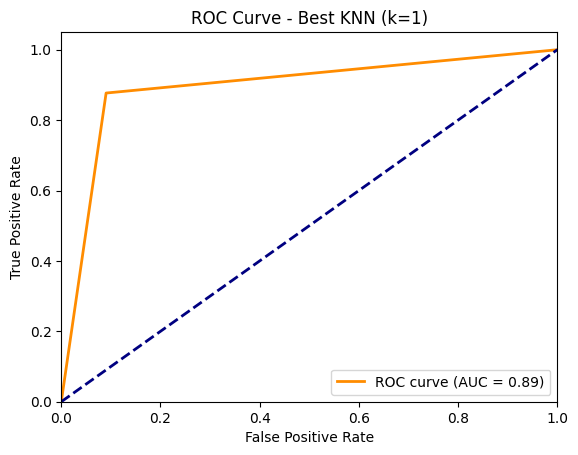

Best SVM Model: RBF SVM (γ=scale)

--- Best SVM (RBF SVM (γ=scale)) Results ---
Accuracy: 0.9349
Precision: 0.9508
Recall: 0.8923
F1 Score: 0.9206
ROC AUC: 0.9787
Training Time: 2.8071s


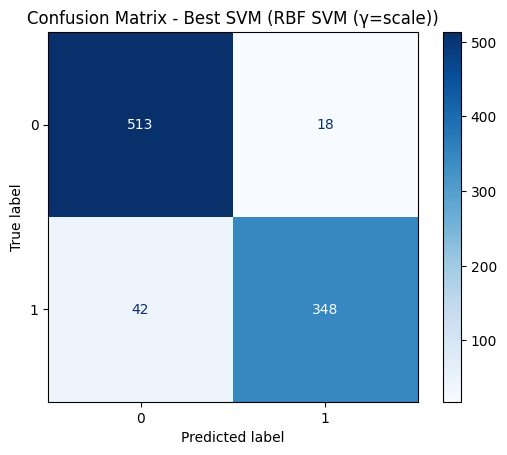

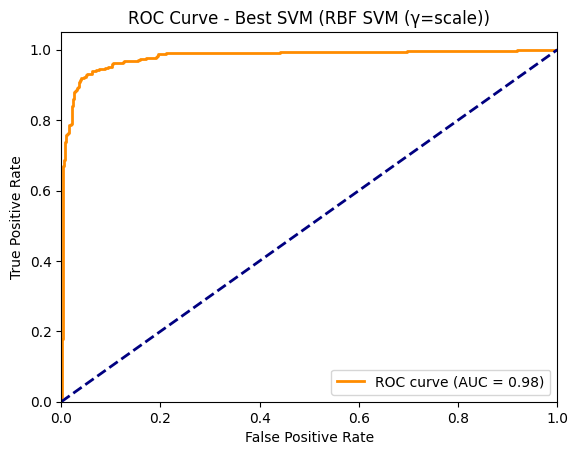

{'accuracy': 0.9348534201954397,
 'precision': 0.9508196721311475,
 'recall': 0.8923076923076924,
 'f1': 0.9206349206349206,
 'train_time': 2.807108163833618,
 'roc_auc': np.float64(0.9786855956347481)}

In [ ]:
## ---------------------
# 8. Model Comparison and Final Results
# ---------------------
print("\n========== Final Model Comparison ==========")

# Get best models from each category by accuracy
best_nb = max(nb_results, key=lambda x: x[1]['accuracy'])
best_knn = max(knn_results, key=lambda x: x[1]['accuracy'])
best_svm = max(svm_results, key=lambda x: x[1]['accuracy'])

# Instantiate the best NB model object
if best_nb[0] == 'GaussianNB':
    best_nb_model = GaussianNB()
elif best_nb[0] == 'MultinomialNB':
    best_nb_model = MultinomialNB()
else:
    best_nb_model = BernoulliNB()

# Instantiate the best KNN model object
best_knn_model = KNeighborsClassifier(n_neighbors=best_knn[0])

# Instantiate the best SVM model object (assumed from the name)
svm_kernel_map = {
    'Linear SVM': ('linear', 1.0),
    'Polynomial SVM (d=2)': ('poly', 1.0),
    'Polynomial SVM (d=3)': ('poly', 1.0),
    'RBF SVM (γ=scale)': ('rbf', 1.0),
    'Sigmoid SVM': ('sigmoid', 1.0)
}
kernel, C_val = svm_kernel_map.get(best_svm[0], ('rbf', 1.0))
degree = 3 if 'd=3' in best_svm[0] else 2 if 'd=2' in best_svm[0] else None

if kernel == 'poly' and degree is not None:
    best_svm_model = SVC(kernel=kernel, degree=degree, C=C_val, probability=True, random_state=42)
else:
    best_svm_model = SVC(kernel=kernel, C=C_val, probability=True, random_state=42)

# Evaluate the best models on test data
print("\nEvaluating Best Models on Test Data:\n")

print(f"Best Naive Bayes Model: {best_nb[0]}")
evaluate_model(best_nb_model, X_train if best_nb[0]=='GaussianNB' else X_train_mm,
               y_train if best_nb[0]=='GaussianNB' else y_train_mm,
               X_test if best_nb[0]=='GaussianNB' else X_test_mm,
               y_test if best_nb[0]=='GaussianNB' else y_test_mm,
               f"Best Naive Bayes ({best_nb[0]})")

print(f"Best KNN Model: k={best_knn[0]}")
evaluate_model(best_knn_model, X_train, y_train, X_test, y_test, f"Best KNN (k={best_knn[0]})")

print(f"Best SVM Model: {best_svm[0]}")
evaluate_model(best_svm_model, X_train, y_train, X_test, y_test, f"Best SVM ({best_svm[0]})")



========== Ensemble Methods: Bagging and Boosting ==========

Random Forest (Bagging)

--- Random Forest (Bagging) Results ---
Accuracy: 0.9555
Precision: 0.9755
Recall: 0.9179
F1 Score: 0.9458
ROC AUC: 0.9857
Training Time: 2.1087s


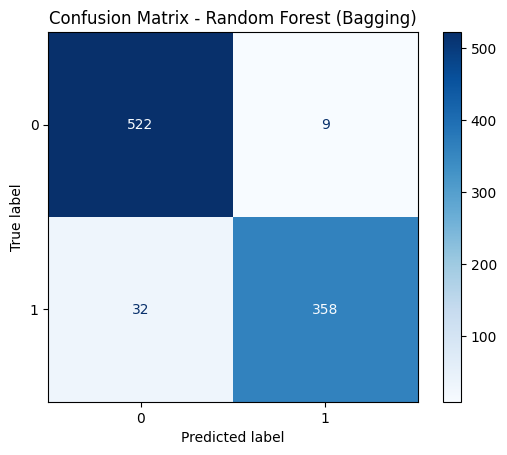

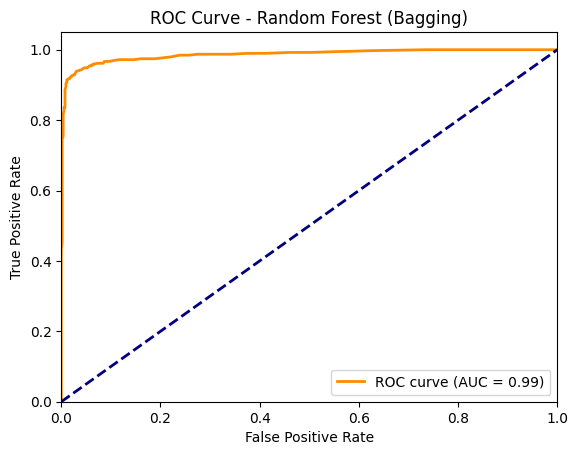


AdaBoost

--- AdaBoost Results ---
Accuracy: 0.9370
Precision: 0.9486
Recall: 0.9000
F1 Score: 0.9237
ROC AUC: 0.9810
Training Time: 2.0353s


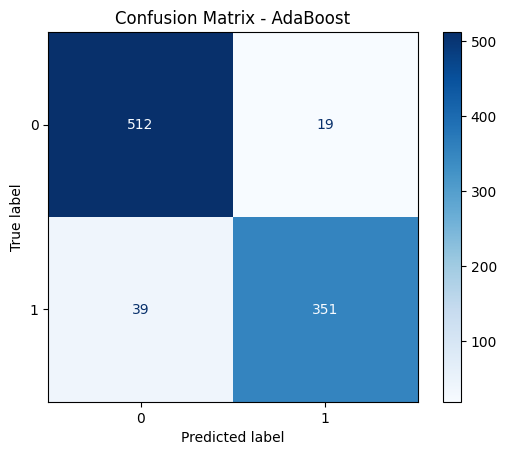

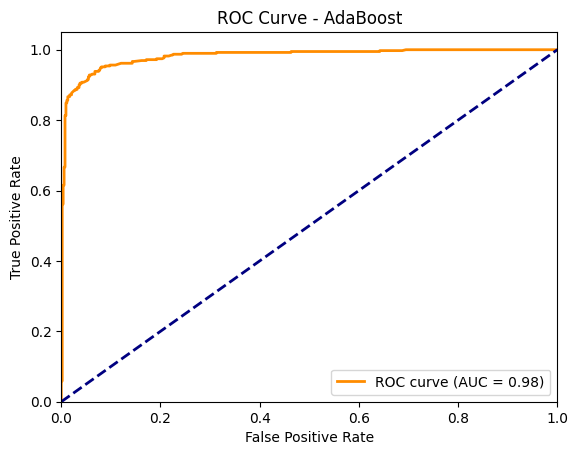


Gradient Boosting

--- Gradient Boosting Results ---
Accuracy: 0.9457
Precision: 0.9620
Recall: 0.9077
F1 Score: 0.9340
ROC AUC: 0.9842
Training Time: 1.9304s


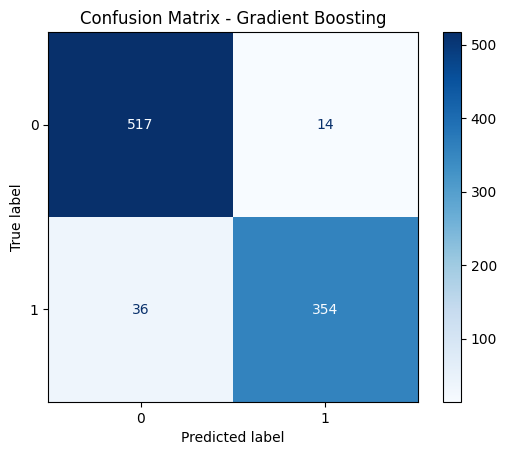

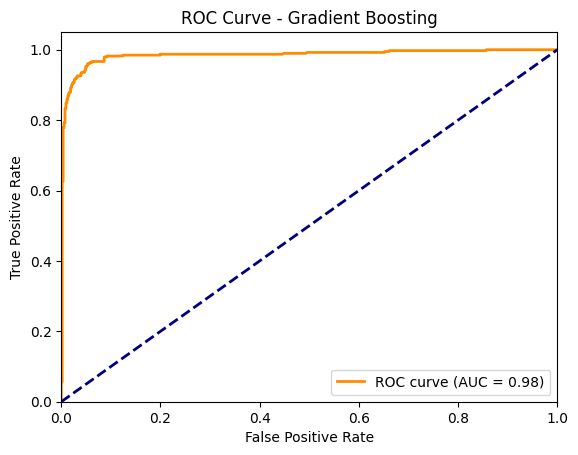


XGBoost

--- XGBoost Results ---
Accuracy: 0.9566
Precision: 0.9679
Recall: 0.9282
F1 Score: 0.9476
ROC AUC: 0.9876
Training Time: 0.5813s


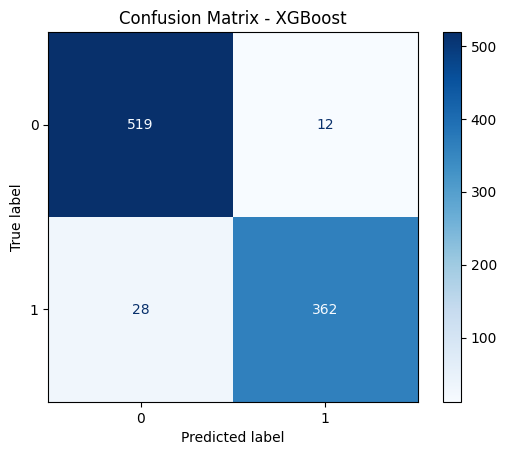

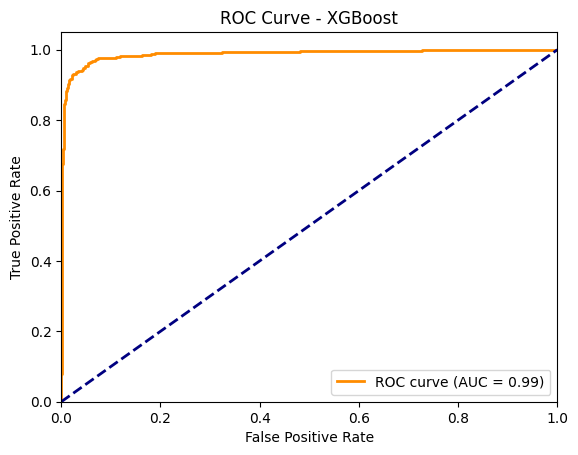


Table 5: Ensemble Method Performance Comparison
Model                     Accuracy   Precision  Recall     F1 Score   ROC AUC   
Random Forest (Bagging)   0.9555     0.9755     0.9179     0.9458     0.9857    
AdaBoost                  0.9370     0.9486     0.9000     0.9237     0.9810    
Gradient Boosting         0.9457     0.9620     0.9077     0.9340     0.9842    
XGBoost                   0.9566     0.9679     0.9282     0.9476     0.9876    


In [ ]:
# ---------------------
# 9. Ensemble Techniques: Bagging and Boosting
# ---------------------
print("\n========== Ensemble Methods: Bagging and Boosting ==========")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Try importing XGBoost
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    print("❗ XGBoost not installed. Skipping XGBoost.")
    xgb_available = False

ensemble_models = {
    'Random Forest (Bagging)': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
}

if xgb_available:
    ensemble_models['XGBoost'] = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)

ensemble_results = []

for name, model in ensemble_models.items():
    print(f"\n{name}")
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    ensemble_results.append((name, metrics))

# ---------------------
# 10. Ensemble Results Table
# ---------------------
print("\nTable 5: Ensemble Method Performance Comparison")
print("{:<25} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
    "Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"))
for name, metrics in ensemble_results:
    print("{:<25} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        name, metrics['accuracy'], metrics['precision'],
        metrics['recall'], metrics['f1'], metrics.get('roc_auc', 0)))
